In [1]:
'''
Data used in this project comes from url https://data.world/data-society/used-cars-data.
It has been scraped from eBay Kleinanzeigen and refers to car selling advertisements published in years 2014-2016.
The main goal of this project is assigning cars produced by five producers which vehicles appear the most often.

At first, we're going to import necessary libraries.'''

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import time
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
'''The second action is a repository cloning from GitHub and dataset loading.'''

!git clone https://github.com/slatkowski/autos_project
path_to_file = 'autos_project/autos.csv'
df = pd.read_csv(path_to_file)
df

fatal: destination path 'autos_project' already exists and is not an empty directory.


index          dateCrawled  \
0            0  2016-03-24 11:52:17   
1            1  2016-03-24 10:58:45   
2            2  2016-03-14 12:52:21   
3            3  2016-03-17 16:54:04   
4            4  2016-03-31 17:25:20   
...        ...                  ...   
371523  371523  2016-03-14 17:48:27   
371524  371524  2016-03-05 19:56:21   
371525  371525  2016-03-19 18:57:12   
371526  371526  2016-03-20 19:41:08   
371527  371527  2016-03-07 19:39:19   

                                                name  seller offerType  price  \
0                                         Golf_3_1.6  privat   Angebot    480   
1                               A5_Sportback_2.7_Tdi  privat   Angebot  18300   
2                     Jeep_Grand_Cherokee_"Overland"  privat   Angebot   9800   
3                                 GOLF_4_1_4__3TÜRER  privat   Angebot   1500   
4                     Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   3600   
...                                              ...     ...       ...    ...   
371523                    Suche_t4___vito_ab_6_sitze  privat   Angebot   2200   
371524         Smart_smart_leistungssteigerung_100ps  privat   Angebot   1199   
371525            Volkswagen_Multivan_T4_TDI_7DC_UY2  privat   Angebot   9200   
371526                        VW_Golf_Kombi_1_9l_TDI  privat   Angebot   3400   
371527  BMW_M135i_vollausgestattet_NP_52.720____Euro  privat   Angebot  28990   

         abtest vehicleType  yearOfRegistration    gearbox  ...        model  \
0          test         NaN                1993    manuell  ...         golf   
1          test       coupe                2011    manuell  ...          NaN   
2          test         suv                2004  automatik  ...        grand   
3          test  kleinwagen                2001    manuell  ...         golf   
4          test  kleinwagen                2008    manuell  ...        fabia   
...         ...         ...                 ...        ...  ...          ...   
371523     test         NaN                2005        NaN  ...          NaN   
371524     test      cabrio                2000  automatik  ...       fortwo   
371525     test         bus                1996    manuell  ...  transporter   
371526     test       kombi                2002    manuell  ...         golf   
371527  control   limousine                2013    manuell  ...      m_reihe   

       kilometer  monthOfRegistration  fuelType           brand  \
0         150000                    0    benzin      volkswagen   
1         125000                    5    diesel            audi   
2         125000                    8    diesel            jeep   
3         150000                    6    benzin      volkswagen   
4          90000                    7    diesel           skoda   
...          ...                  ...       ...             ...   
371523     20000                    1       NaN  sonstige_autos   
371524    125000                    3    benzin           smart   
371525    150000                    3    diesel      volkswagen   
371526    150000                    6    diesel      volkswagen   
371527     50000                    8    benzin             bmw   

       notRepairedDamage          dateCreated nrOfPictures  postalCode  \
0                    NaN  2016-03-24 00:00:00            0       70435   
1                     ja  2016-03-24 00:00:00            0       66954   
2                    NaN  2016-03-14 00:00:00            0       90480   
3                   nein  2016-03-17 00:00:00            0       91074   
4                   nein  2016-03-31 00:00:00            0       60437   
...                  ...                  ...          ...         ...   
371523               NaN  2016-03-14 00:00:00            0       39576   
371524              nein  2016-03-05 00:00:00            0       26135   
371525              nein  2016-03-19 00:00:00            0       87439   
371526               NaN  2016-03-20 00:00:00            0   

In [3]:
'''Next we should count all values - function to use in this purpose is defined below.'''

def DFCounter(df):
    for col in df.columns:
        print(df[col].value_counts())
        print('_______________________')
        
DFCounter(df)

0         1
247692    1
247690    1
247689    1
247688    1
         ..
123841    1
123840    1
123839    1
123838    1
371527    1
Name: index, Length: 371528, dtype: int64
_______________________
2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-22 10:42:10    5
2016-04-01 16:52:05    5
                      ..
2016-03-20 15:56:21    1
2016-03-14 03:22:32    1
2016-03-14 22:52:34    1
2016-03-31 23:53:26    1
2016-03-07 19:39:19    1
Name: dateCrawled, Length: 280500, dtype: int64
_______________________
Ford_Fiesta                                              657
BMW_318i                                                 627
Opel_Corsa                                               622
Volkswagen_Golf_1.4                                      603
BMW_316i                                                 523
                                                        ... 
Audi_A4_Avant_Klima_Gruene_Plakette_TÜV_&AU_NEU_XENON      1
Renault_clio_in_gold_450VB_!

In [4]:
'''"Andere" means "other" in German.
These values can hide any other value from adequate column,
so replacing them with NaN would be a correct action.'''

df.replace('andere', np.nan, inplace=True)

In [5]:
'''We have to check when the first and the last advertisement
have been published to make data filtering correct.'''

df['dateCreated'] = pd.to_datetime(df['dateCreated'])
df['lastSeen'] = pd.to_datetime(df['lastSeen'])

print(f"Date of the first advertisement: {df['dateCreated'].min()}.")
print(f"Date of the last advertisement: {df['dateCreated'].max()}.")

Date of the first advertisement: 2014-03-10 00:00:00.
Date of the last advertisement: 2016-04-07 00:00:00.


In [6]:
'''Duration of advertisement appearance on the site (expressed in hours) can be also useful feature.
It may show how attractive cars from particular brands are.
To create this feature, as a DataFrame column, we need to subtract values from columns
"lastSeen" and "dateCreated", and divide them by instance of class pd.Timedelta.'''

delta = pd.Timedelta(hours=1)

df['advertDuration'] = (df['lastSeen'] - df['dateCreated'])/delta
df['advertDuration']

0         339.282500
1         337.780556
2         540.796111
3          17.671389
4         154.289167
             ...    
371523    552.781111
371524    162.286667
371525    463.257222
371526    108.755833
371527    363.286111
Name: advertDuration, Length: 371528, dtype: float64

In [7]:
'''Column "index" contains unique values from 0 to 371528, so we can set it as index column.'''

df.set_index('index', inplace=True)

In [8]:
'''First information about a DataFrame columns names, non-null values and data types.
Columns "vehicleType", "gearbox", "model", "fuelType" and "notRepairedDamage" contain NaN values.
Also some of the columns which should be the base of prediction, like "vehicleType", "fuelType" or
"gearbox" are object (str) columns.'''

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  object        
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  int64         
 5   abtest               371528 non-null  object        
 6   vehicleType          330302 non-null  object        
 7   yearOfRegistration   371528 non-null  int64         
 8   gearbox              351319 non-null  object        
 9   powerPS              371528 non-null  int64         
 10  model                324644 non-null  object        
 11  kilometer            371528 non-null  int64         
 12  monthOfRegistration  371528 non-null  int64         
 13  fuelType      

In [9]:
'''Next, take a look at the descriptive statistics of DataFrame
(values round to two places after a comma to better readability).
Unfortunately, there are many outliers - maximum value of column "price"
overpasses 2 bilions of euro, we have value (values) with price = 0,
in column "yearOfRegistration" we have cars "registered" in year 1000 and 9999.
Also column "kilometer" may show not enough variance - max value (150000)
appears as a median.'''

df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

price yearOfRegistration    powerPS  kilometer  \
count      371528.00          371528.00  371528.00  371528.00   
mean        17295.14            2004.58     115.55  125618.69   
std       3587953.74              92.87     192.14   40112.34   
min             0.00            1000.00       0.00    5000.00   
25%          1150.00            1999.00      70.00  125000.00   
50%          2950.00            2003.00     105.00  150000.00   
75%          7200.00            2008.00     150.00  150000.00   
max    2147483647.00            9999.00   20000.00  150000.00   

      monthOfRegistration nrOfPictures postalCode advertDuration  
count           371528.00    371528.00  371528.00      371528.00  
mean                 5.73         0.00   50820.67         223.92  
std                  3.71         0.00   25799.08         207.94  
min                  0.00         0.00    1067.00           0.43  
25%                  3.00         0.00   30459.00          61.53  
50%                  6.00         0.00   49610.00         156.74  
75%                  9.00         0.00   71546.00         338.26  
max                 12.00         0.00   99998.00       18220.77

In [10]:
'''To replace NaNs with values we should define a function
which replaces them with values according to probability of their appearance
in the column where NaNs appear.'''

from collections import Counter
import random
def NANFiller(df):
    #1. calling function columnFiller to modify column
    def columnFiller(series):
        #2. assigning number of NaN-s in column to a variable
        nan_c = len(series[series.isna()])
        #3. taking values from column with no NaN and assigning them to a temporary Series
        nnan_c = series[series.notna()]
        #4. counting not-NaN values from temporary Series
        count_nn = Counter(nnan_c)    
        #5. choosing random values according to probabilities of their apperance
        new_val = random.choices(list(count_nn.keys()), weights = list(count_nn.values()), k=nan_c)
        series[series.isna()] = new_val
        #6. returning column with new values
        return series
    #6. repeating operation above for the whole DataFrame
    for col in df.columns:
        df[col]=columnFiller(df[col])
        
NANFiller(df)

In [11]:
'''The next description of DataFrame - as we can see, NaNs have been replaced.
We can assume that the columns used in prediction should have numeric values
(except for column "nrOfPicture" in which we have only one value)
and columns "vehicleType", "gearbox", "fuelType" and "postalCode"
with values transformed into discrete numbers.'''

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  object        
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  float64       
 5   abtest               371528 non-null  object        
 6   vehicleType          371528 non-null  object        
 7   yearOfRegistration   371528 non-null  float64       
 8   gearbox              371528 non-null  object        
 9   powerPS              371528 non-null  float64       
 10  model                371528 non-null  object        
 11  kilometer            371528 non-null  float64       
 12  monthOfRegistration  371528 non-null  float64       
 13  fuelType      

In [12]:
'''Just like it was said at the beginning, we're interested only in predicting
five most popular brands: VW, BMW, Mercedes-Benz, Opel and Audi.'''

df = df.loc[(df.brand == 'volkswagen') | (df.brand == 'bmw') | (df.brand == 'mercedes_benz') | (df.brand == 'opel') | (df.brand == 'audi')]

In [13]:
'''The next operation is getting rid of outliers. We're taking into consideration only cars not registered earlier 
than in 1980, with price in price bracket 250-40000 euros and engine power (in HP/PS) bracket 40 
(the power of engines mounted in the weakest versions of popular models VW 1302/1303 Beetle and VW Polo) to 500 
(majority of brands, predominantly Mercedes-Benz, have more powerful models, but they are not in common use
and can be considered as outliers). Also we aren't going to consider adverts present on the website
no longer that 840 hours (35 days, which means 5 full weeks).'''

df = df[(df['yearOfRegistration'] >= 1980) & (df['yearOfRegistration'] <= 2016)]
df = df[(df['price'] >= 250) & (df['price'] <= 40000)]
df = df[(df['powerPS'] >= 40) & (df['powerPS'] <= 500)]
df = df[df['advertDuration']<=840]

In [14]:
'''We can see that operations above made the dataset about two times smaller.
Number of samples decreased from 371528 to 188485.'''

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188485 entries, 1 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          188485 non-null  object        
 1   name                 188485 non-null  object        
 2   seller               188485 non-null  object        
 3   offerType            188485 non-null  object        
 4   price                188485 non-null  float64       
 5   abtest               188485 non-null  object        
 6   vehicleType          188485 non-null  object        
 7   yearOfRegistration   188485 non-null  float64       
 8   gearbox              188485 non-null  object        
 9   powerPS              188485 non-null  float64       
 10  model                188485 non-null  object        
 11  kilometer            188485 non-null  float64       
 12  monthOfRegistration  188485 non-null  float64       
 13  fuelType      

In [15]:
'''Now let's transform postal codes into categories. Basing on an postal division of Germany 
(into 10 leitzones from 0 to 9: https://en.wikipedia.org/wiki/Postal_codes_in_Germany) 
we can take 10 categories.'''

bins = [0, 9999, 19999, 29999, 39999,
        49999, 59999, 69999, 79999, 89999, 99999]

df['postalCode'] = pd.cut(df['postalCode'], bins=bins,
       labels=['Leitzone 0', 'Leitzone 1', 'Leitzone 2', 'Leitzone 3',
              'Leitzone 4', 'Leitzone 5', 'Leitzone 6', 'Leitzone 7',
              'Leitzone 8', 'Leitzone 9'])

In [16]:
bins = [0, 149999, 999999]

df['kilometer'] = pd.cut(df['kilometer'], bins=bins,
                         labels=['Less than 150000 km', 'Over 150000 km'])

In [17]:
DFCounter(df)

2016-03-23 14:45:14    4
2016-03-15 19:52:57    4
2016-03-05 16:06:19    4
2016-03-12 17:44:46    4
2016-03-08 20:39:44    4
                      ..
2016-03-14 08:52:20    1
2016-03-30 00:58:26    1
2016-03-14 09:48:53    1
2016-03-14 17:50:36    1
2016-03-07 19:39:19    1
Name: dateCrawled, Length: 163852, dtype: int64
_______________________
BMW_318i                                                      620
Volkswagen_Golf_1.4                                           581
BMW_316i                                                      518
BMW_320i                                                      488
Opel_Corsa                                                    428
                                                             ... 
A_klasse_Mercedes                                               1
Audi_A4_2_7TDI                                                  1
Golf_TDI_2.0___Neu_TÜV                                          1
Bmw_Z3_1_9_118PS_mit_original_93tkm_Klima_&_Sitzh._TÜV_neu 

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188485 entries, 1 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          188485 non-null  object        
 1   name                 188485 non-null  object        
 2   seller               188485 non-null  object        
 3   offerType            188485 non-null  object        
 4   price                188485 non-null  float64       
 5   abtest               188485 non-null  object        
 6   vehicleType          188485 non-null  object        
 7   yearOfRegistration   188485 non-null  float64       
 8   gearbox              188485 non-null  object        
 9   powerPS              188485 non-null  float64       
 10  model                188485 non-null  object        
 11  kilometer            188485 non-null  category      
 12  monthOfRegistration  188485 non-null  float64       
 13  fuelType      

In [19]:
'''Now we have to balance classes - at first, let's count them.'''

df['brand'].value_counts()

volkswagen       64637
bmw              34780
opel             31255
mercedes_benz    29495
audi             28318
Name: brand, dtype: int64

In [20]:
'''Audi is the least numerous - 28318 adverts.
To make our model more sensible to each class and metrics intuitive,
we have to make quantity of adverts in brands equal.'''

min_cnt = df['brand'].value_counts().min()
df = df.groupby('brand').sample(min_cnt)

df['brand'].value_counts()

audi             28318
bmw              28318
mercedes_benz    28318
opel             28318
volkswagen       28318
Name: brand, dtype: int64

In [21]:
'''Next we have to drop the columns with no importance in modelling.'''

df.drop(columns=['dateCrawled', 'name', 'seller', 'offerType', 'abtest', 'model', 'monthOfRegistration',
       'dateCreated', 'nrOfPictures', 'lastSeen'], inplace=True)

In [22]:
df.columns

Index(['price', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'kilometer', 'fuelType', 'brand', 'notRepairedDamage', 'postalCode',
       'advertDuration'],
      dtype='object')

In [23]:
'''To transform columns with strings into categorical,
we'll define function based on LabelEncoder.'''

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encode_list = ['gearbox', 'vehicleType', 'fuelType', 'postalCode', 'notRepairedDamage', 'kilometer']

def EncodingDesc(series, le):
    #1. transformation of pd.Series/pd.DataFrame.column
    transformed = le.fit_transform(series)
    #2. displaying the name of Series/column
    print(series.name)
    #3. displaying names of unique classes
    print(le.classes_)
    #4. displaying classes values after encoding
    print(np.unique(transformed))
    #5. returning transformed Series/column
    return transformed

for i in encode_list:
    df[i] = EncodingDesc(df[i], le)
    print('______________________')


gearbox
['automatik' 'manuell']
[0 1]
______________________
vehicleType
['bus' 'cabrio' 'coupe' 'kleinwagen' 'kombi' 'limousine' 'suv']
[0 1 2 3 4 5 6]
______________________
fuelType
['benzin' 'cng' 'diesel' 'elektro' 'hybrid' 'lpg']
[0 1 2 3 4 5]
______________________
postalCode
['Leitzone 0' 'Leitzone 1' 'Leitzone 2' 'Leitzone 3' 'Leitzone 4'
 'Leitzone 5' 'Leitzone 6' 'Leitzone 7' 'Leitzone 8' 'Leitzone 9']
[0 1 2 3 4 5 6 7 8 9]
______________________
notRepairedDamage
['ja' 'nein']
[0 1]
______________________
kilometer
['Less than 150000 km' 'Over 150000 km']
[0 1]
______________________


In [24]:
'''Last description of basic statistics should show us that the data are ready to processing.'''

df.describe().apply(lambda x: x.apply('{0:.2f}'.format))

price vehicleType yearOfRegistration    gearbox    powerPS  \
count  141590.00   141590.00          141590.00  141590.00  141590.00   
mean     6827.20        3.64            2003.11       0.70     142.07   
std      7118.97        1.61               6.12       0.46      60.67   
min       250.00        0.00            1980.00       0.00      40.00   
25%      1700.00        3.00            1999.00       0.00     101.00   
50%      4199.00        4.00            2003.00       1.00     136.00   
75%      9500.00        5.00            2008.00       1.00     170.00   
max     40000.00        6.00            2016.00       1.00     500.00   

       kilometer   fuelType notRepairedDamage postalCode advertDuration  
count  141590.00  141590.00         141590.00  141590.00      141590.00  
mean        0.70       0.84              0.90       4.76         228.34  
std         0.46       1.11              0.30       2.56         201.40  
min         0.00       0.00              0.00       0.00           0.60  
25%         0.00       0.00              1.00       3.00          63.37  
50%         1.00       0.00              1.00       5.00         161.76  
75%         1.00       2.00              1.00       7.00         343.84  
max         1.00       5.00              1.00       9.00         839.26

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141590 entries, 118246 to 142622
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               141590 non-null  float64
 1   vehicleType         141590 non-null  int32  
 2   yearOfRegistration  141590 non-null  float64
 3   gearbox             141590 non-null  int32  
 4   powerPS             141590 non-null  float64
 5   kilometer           141590 non-null  int32  
 6   fuelType            141590 non-null  int32  
 7   brand               141590 non-null  object 
 8   notRepairedDamage   141590 non-null  int32  
 9   postalCode          141590 non-null  int32  
 10  advertDuration      141590 non-null  float64
dtypes: float64(4), int32(6), object(1)
memory usage: 9.7+ MB


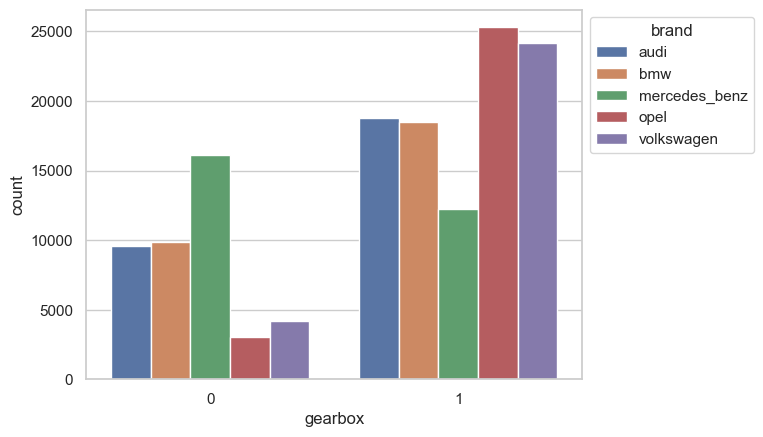

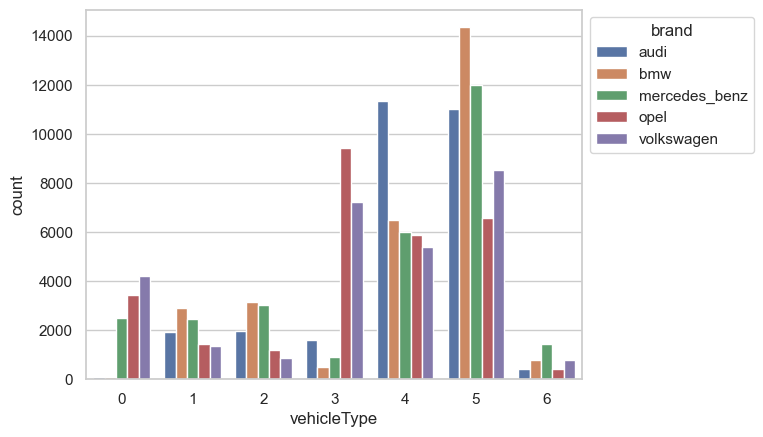

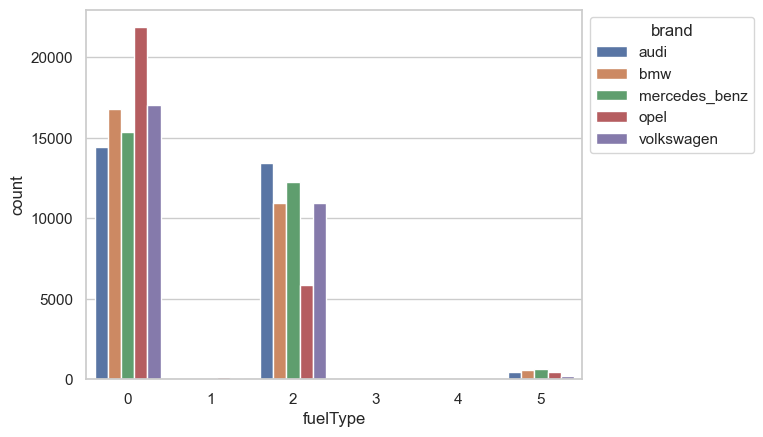

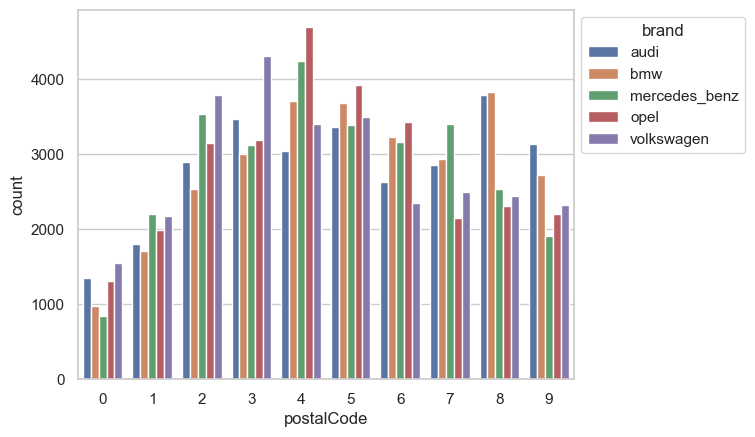

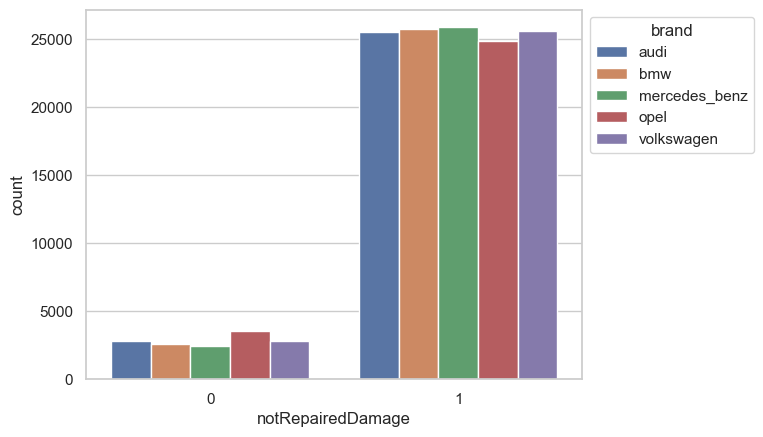

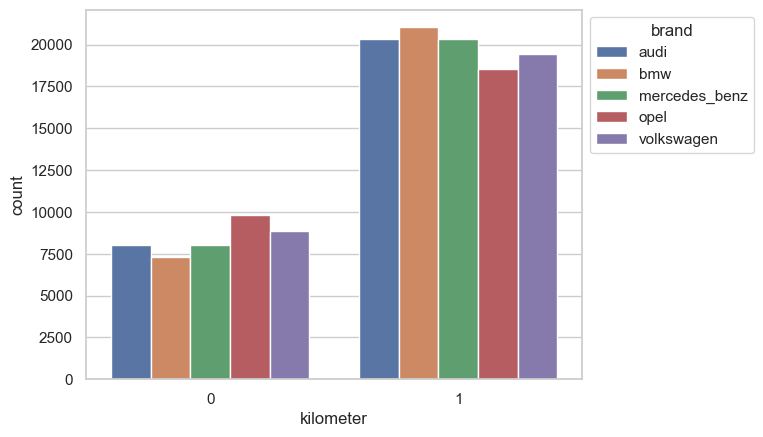

In [26]:
'''To visualize values, we'll take the convention:
- discrete values will be visualize by countplots,
- to visualize continuous variable we'll use KDE Plot.'''

'''First group of plots shows that:

1. Mercedes-Benz is the only brand appearing in adverts with more models with automatic (0) than manual (1) gearbox. The remaining brands has advantage
in manual gearboxes; BMW and Audi have 2 times more models with them, VW and Opel 4-5 times more.

2. Variance in "vehicleType" column is interesting. Offers with Audi are rich when it comes to combis (4) and limousines (5), but the other types
are relatively rare. About a half of available BMWs are limousines, combis are two times less frequent, offer of cabrios (1) and coupes (2) is quite rich too,
the other types are marginal. Mercedes-Benz has great amount of limousines, too. Adverts with this brand have also visible amount of buses (0) and SUVs (6).
Opel is the the only brand offering the biggest amount of hatchbacks (3, in dataset named "kleinwagen" - literally "little car"). VW has relatively 
the most diverse palette of car types.

3. Each one of brand is characterised by more gasoline (0) than diesel (2) engines in column "fuelType". Advantage of gasoline engines is, except for Opel, not big.
Very rare are offers with LPG fuel types (5), CNG (1), electric (3) and hybrid (4) engines appear in individual cases.

4. Column "notRepairedDamage" doesn't provide any variance. Adverts in each class are more frequently concerning non-damaged (1) cars, damaged (0) 
appear 6-7 less often. Similar situation shows up on plot referring to "kilometer" column.

5. Opels are the most often for sale in Leitzones 4, 5, 6 (west of Germany). Leitzones 8 and 9 (south-eastern and part of central Germany) are the only regions
where Audis and BMWs appear the most frequent. VW "wins" in Leitzone 0 (east of Germany), 2 (north of Germany) and 3 (large part of central Germany), and is
only a little less popular than Mercedes-Benz in Leitzone 1 (north-eastern Germany with the capital city of Berlin). Mercedes' advert frequency is relatively the biggest
is Leitzone 1 and 7 (south-western Germany).

'''

sns.set(style="whitegrid") 

for i, col in enumerate(df[encode_list]):
    plt.figure(i)
    ax = sns.countplot(x=col, data=df, hue='brand')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

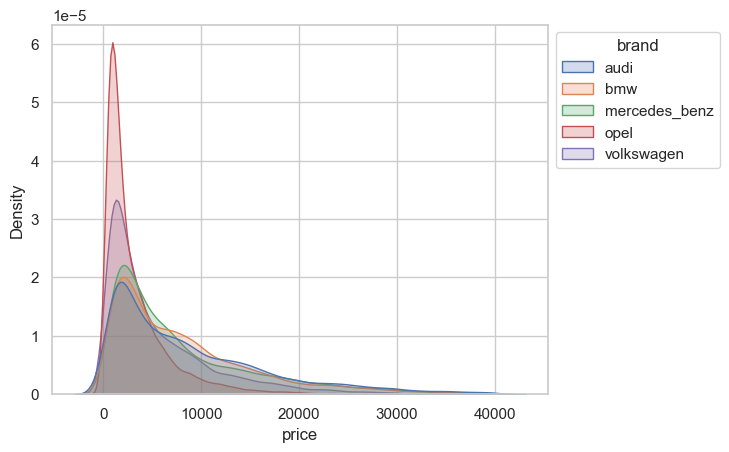

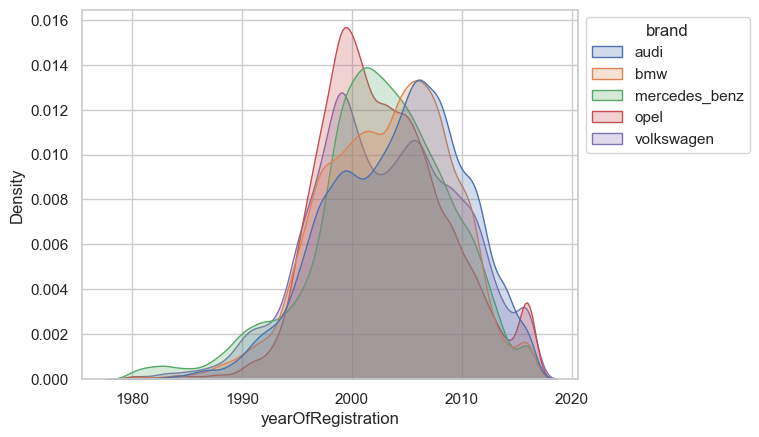

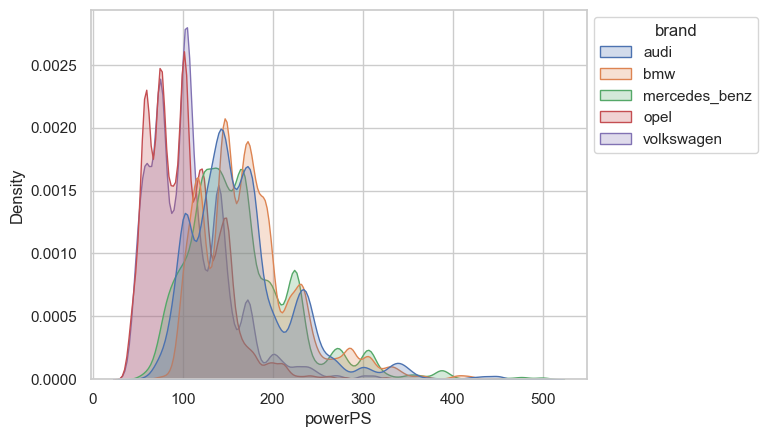

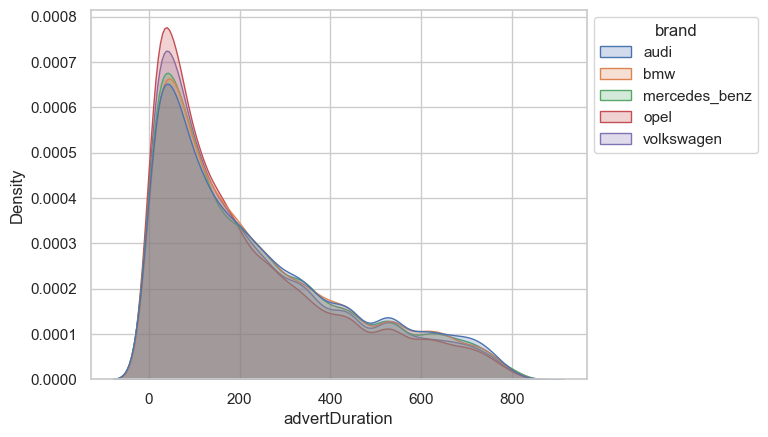

In [27]:
'''When it comes to continuous variables:

1. Opel is much cheaper than other brands and exhaust the distribution before 25000 euros. BMW, Audi and Mercedes-Benz
have similar increment of price and gain 100% at about 45000-50000 euros. VW is centrally in the middle between them.
Peak of all brands' adverts frequency is at level about 1500-3000 euros. All distributions are strictly positive skew.

2. Mercedes-Benz has the greatest amount of models older from years 1980-1994 available. The biggest amount of Opels and VWs
comes from last years of XX century, Mercedeses - from the first half of 00s' of XXI century, BMWs and Audis - the second half
of 00s. For each producer distrubitions of these feature are close to normal.

3. VWs and Opels has much less powerful models and distrubutions of them are similar. BMW has models no less powerful than 70 HP,
Audi's and Mercedes-Benz's distributions have minimal values at the same point but Audi's reach its peak near BMW's.
VW's and Opel's cars power rarely overpass 250 HP, on the other hand there are quite a lot of BMW's, Audi's and Mercedes' 
vehicles with powers above 320 HP.

4. Distrubution showing duration of adverts (which we can consider as effectiveness of advert - how long does it take to sell 
a car from the publication) are quite similar and positive skew - the most adverts cause the transaction in 2-3 days.
The leaders in these category are the brands regarded as the popular brands - VW and Opel.

'''


for i, col in enumerate(df[['price', 'yearOfRegistration', 'powerPS', 'advertDuration']]):
    plt.figure(i)
    ax = sns.kdeplot(x=col, data=df, hue='brand', fill=True)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [28]:
'''Now let's generate the full report of data. As we can see, there are not much variables with strong correlation. 
Quite strong positive correlation takes place between price and registration year or engine power.
Negative correlation occurs between mileage and registration year or price and between gearbox type and engine power.
Car brands don't correlate strong with any of the other variables, but that's positive signal, because there's no "data leak".
The only continuous variable with distrubution quite similar to normal/Gaussian is the year of registration, 
the rest have strictly skew distributions.'''

report = ProfileReport(df, infer_dtypes=False)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
'''Using a pivot table we can take a look at descriptive stats of each brand.
Basing on mean, standard deviation and our previous observations we can see 
that the variables providing the greatest variance are: fuel type, engine power, price and vehicle type.'''

pivot = pd.pivot_table(df, index='brand', values = ['price', 'vehicleType', 'yearOfRegistration', 'kilometer',
                                                    'notRepairedDamage', 'gearbox', 'powerPS', 'fuelType','postalCode'], 
                       aggfunc= [np.mean, np.median, np.std, min, max])
pd.options.display.max_columns = None
display(pivot)

mean                                                   \
               fuelType   gearbox kilometer notRepairedDamage postalCode   
brand                                                                      
audi           1.026026  0.662653  0.717671          0.900487   4.986546   
bmw            0.877534  0.652518  0.742955          0.909598   5.084893   
mercedes_benz  0.985804  0.431598  0.717282          0.913059   4.686242   
opel           0.498093  0.893425  0.654354          0.875909   4.593156   
volkswagen     0.816442  0.853203  0.686101          0.901900   4.439508   

                                                                       \
                  powerPS        price vehicleType yearOfRegistration   
brand                                                                   
audi           163.983332  8892.655343    4.006109        2004.055724   
bmw            173.277244  8311.422735    3.999011        2003.202062   
mercedes_benz  164.270464  8095.957942    3.663076        2002.559467   
opel           101.655166  3238.221379    3.212727        2002.749311   
volkswagen     107.183593  5597.763084    3.304188        2002.987817   

                median                                                         \
              fuelType gearbox kilometer notRepairedDamage postalCode powerPS   
brand                                                                           
audi                 0       1         1                 1          5   150.0   
bmw                  0       1         1                 1          5   170.0   
mercedes_benz        0       0         1                 1          5   150.0   
opel                 0       1         1                 1          4   101.0   
volkswagen           0       1         1                 1          4   102.0   

                                                           std            \
                price vehicleType yearOfRegistration  fuelType   gearbox   
brand                                                                      
audi           6500.0           4             2005.0  1.110421  0.472813   
bmw            6150.0           5             2004.0  1.135818  0.476179   
mercedes_benz  5450.0           4             2003.0  1.163783  0.495308   
opel           1890.0           3             2002.0  0.987820  0.308578   
volkswagen     3390.0           4             2003.0  1.039528  0.353910   

                                                                              \
              kilometer notRepairedDamage postalCode    powerPS        price   
brand                                                                          
audi           0.450141          0.299354   2.682567  57.517933  8167.249381   
bmw            0.437012          0.286762   2.541932  54.569544  7503.601681   
mercedes_benz  0.450328          0.281754   2.464633  61.354362  7674.403138   
opel           0.475587          0.329691   2.476216  39.020984  3647.571518   
volkswagen     0.464084          0.297455   2.595507  45.088460  5977.041631   

                                                  min                    \
              vehicleType yearOfRegistration fuelType gearbox kilometer   
brand                                                                     
audi             1.202080           6.095953        0       0         0   
bmw              1.437642           5.814388        0       0         0   
mercedes_benz    1.780445           6.318593        0       0         0   
opel             1.598244           5.635493        0       0         0   
volkswagen       1.763898           6.563591        0       0         0   

                                                                       \
              notRepairedDamage postalCode powerPS  price vehicleType   
brand                                                                   
audi                          0          0    50.0  250.0           0   
bmw                           0  

In [30]:
'''Now we can divide dataset to features (X) and labels (y).'''

X = df.drop(columns='brand')
y = df['brand']

In [31]:
'''As we can see below, division of the set ended successfully.'''
print(X.sample(5))
print(y.sample(5))

            price  vehicleType  yearOfRegistration  gearbox  powerPS  \
df_index                                                               
257260      400.0            3              1996.0        1     40.0   
324380     1200.0            3              1996.0        0     60.0   
173053    18499.0            4              2011.0        1    170.0   
68234     20250.0            4              2010.0        0    211.0   
292974      390.0            4              1995.0        1     90.0   

          kilometer  fuelType  notRepairedDamage  postalCode  advertDuration  
df_index                                                                      
257260            1         0                  1           3       52.277222  
324380            0         0                  1           6      406.763611  
173053            0         2                  1           8      225.318611  
68234             0         0                  1           0      541.281111  
292974            1  

In [32]:
'''Now we should encode brand names into categorical numbers.'''

y = le.fit_transform(y)
print(y)
print(type(y))

[0 0 0 ... 4 4 4]
<class 'numpy.ndarray'>


In [33]:
'''We're going to need split the sets on training, validation and test via train_test_split method.'''

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (84954, 10)
X_val shape: (28318, 10)
X_test shape: (28318, 10)
y_train shape: (84954,)
y_val shape: (28318,)
y_test shape: (28318,)


In [34]:
'''Now we will implement the model chosen during the earlier works. This one will be RandomForestClassifier instance.
Advantages of this algorithm is stability, immunity to overfitting and strong predicting force, compared to neural networks, 
(but much easier to implement and faster to fit) and ability to recognize dependencies between data, unable to see by other
sklearn algorithms.
This model also doesn't demand standarized data. We can use them, but it doesn't have influence on training
and when it comes to visualization, it makes the data less readable.'''

from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(max_depth=19,
                                max_features=None)

start = time.time()
rfc_model.fit(X_train, y_train)
rfc_model_train_pred = rfc_model.predict(X_train)
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time of selected RandomForestClassifier model: {mins} mins and {seconds} s.")

Training time of selected RandomForestClassifier model: 0 mins and 30 s.


In [35]:
'''Model has 96% accuracy on training set, 79% on validation and 79% on test set. We need to remember that dependencies
between data are not obvious and each other sklearn classifier had big problems with catching them.
Therefore this model's ability to generalize should be regarded as very strong.'''

from sklearn.metrics import classification_report

rfc_model_val_pred = rfc_model.predict(X_val)
rfc_model_test_pred = rfc_model.predict(X_test)
print(f'Training metrics:\n\n{classification_report(y_train, rfc_model_train_pred)}')
print('_____________________________________________________\n')
print(f'Validation metrics:\n\n{classification_report(y_val, rfc_model_val_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rfc_model_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     16991
           1       0.93      0.97      0.95     16991
           2       0.98      0.96      0.97     16991
           3       0.97      0.97      0.97     16990
           4       0.98      0.93      0.95     16991

    accuracy                           0.96     84954
   macro avg       0.96      0.96      0.96     84954
weighted avg       0.96      0.96      0.96     84954

_____________________________________________________

Validation metrics:

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      5663
           1       0.80      0.85      0.83      5664
           2       0.84      0.82      0.83      5663
           3       0.81      0.83      0.82      5664
           4       0.75      0.70      0.72      5664

    accuracy                           0.79     28318
   macro avg       0.79      0.79   

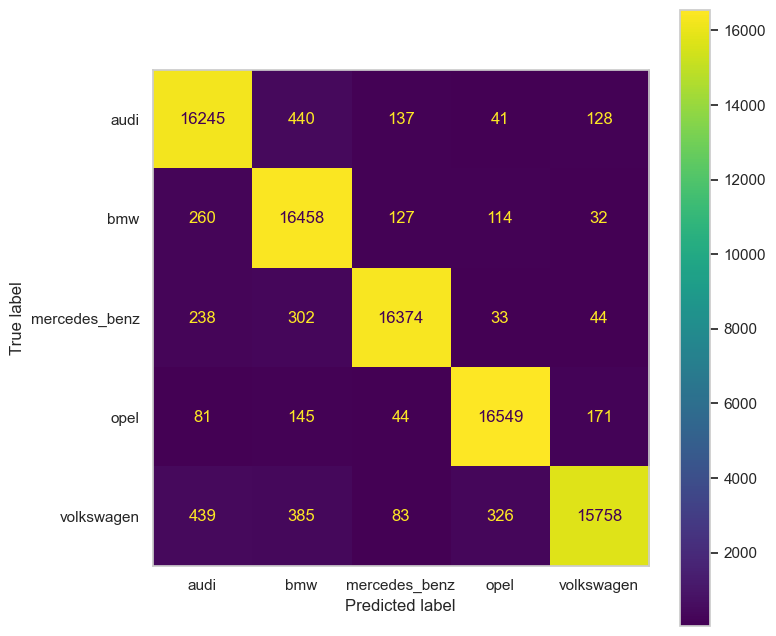

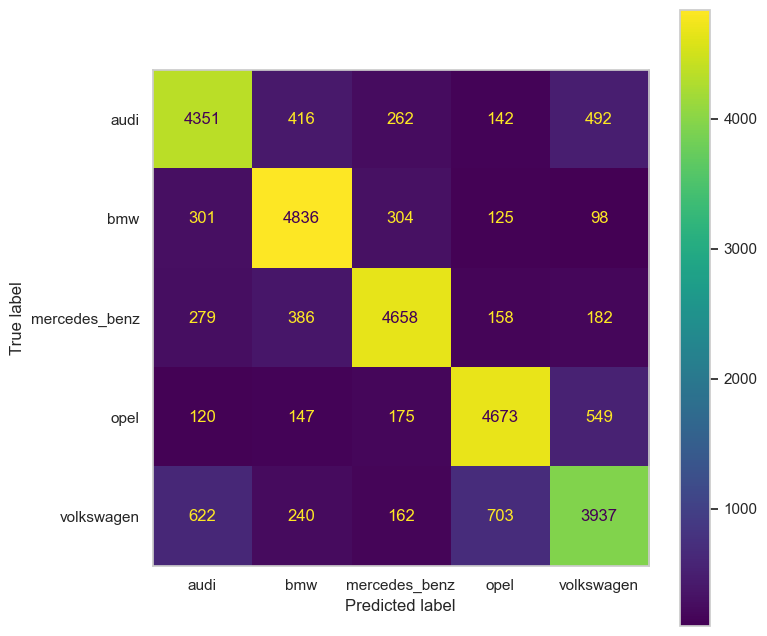

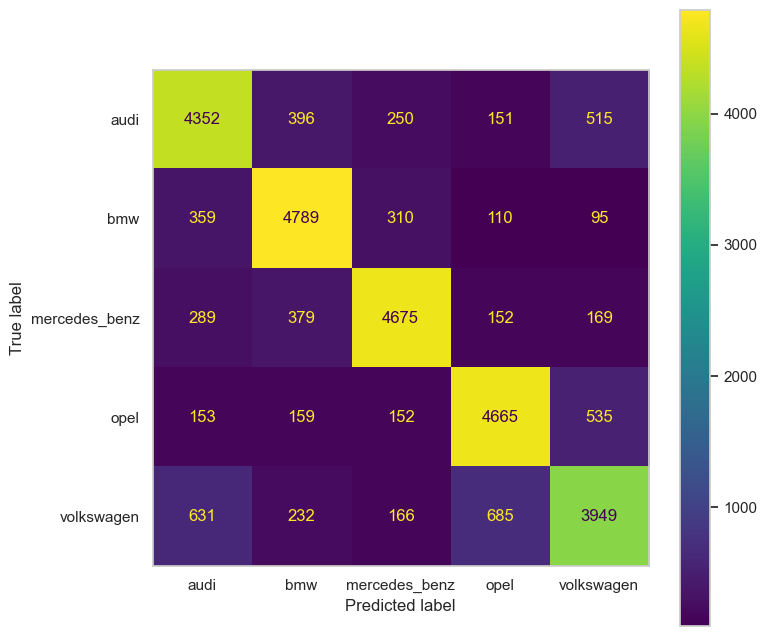

In [36]:
'''We should display confusion matrix. Let's create function in this purpose.'''

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

brands = le.classes_

def conf_matrix_show(estimator, X, y, classes):
    #1. Drawing the plot, setting the plot's default size.
    fig, ax = plt.subplots(figsize=(8,8))
    #2. Creating the instance of confusion matrix from estimator and set, and displaying classes to predict.
    cmd = ConfusionMatrixDisplay.from_estimator(estimator, X, y, display_labels=classes, ax=ax)
    #3. Disabling grid - it makes confusion matrix much more readable. 
    ax.grid(False)

    
conf_matrix_show(rfc_model, X_train, y_train, brands)
conf_matrix_show(rfc_model, X_val, y_val, brands)
conf_matrix_show(rfc_model, X_test, y_test, brands)

In [39]:
'''Model has the weakest predicting strength when it comes to VWs (they're relatively often misrecognized as Opels and Audis),
but copes with its predefined task well.'''

"Model has the weakest predicting strength when it comes to VWs (they're relatively often misrecognized as Opels and Audis),\nbut copes with its predefined task well."

In [40]:
'''Next model we created is the deep neural network model with dense layers.
This kind of layers is the most adequate to tabular data, unstructurized data.
We should start with normalizing the X values.'''

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.fit_transform(X_val)
X_test_sc = scaler.transform(X_test)

In [43]:
"""We're going to try two models using deep learning.
The model used below uses pretty expanded architecture - 7 hidden layers (640-320-160-80-40-20-10 neurons) with ReLU activation function
and exit layer with 5 neurons (1 for each class) and exit function Softmax.
We'll also set EarlyStopping patience = 6, therefore after 6 epochs with no progress in accuracy on validation set
training will be interrupted."""

import tensorflow as tf

tf.random.set_seed(42)

deep_model = tf.keras.Sequential([
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dense(320, activation='relu'),
    tf.keras.layers.Dense(160, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax') #so
])

deep_model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                  patience=6)
]

start = time.time()

history = deep_model.fit(
    X_train_sc, y_train, batch_size=32,
    validation_data=(X_val_sc, y_val),
    epochs=60, callbacks=callback
)
    
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time of selected Keras Dense model: {mins} mins and {seconds} s.")

Epoch 1/60
2655/2655 [==============================] - 20s 7ms/step - loss: 1.2556 - accuracy: 0.4346 - val_loss: 1.1732 - val_accuracy: 0.4812
Epoch 2/60
2655/2655 [==============================] - 21s 8ms/step - loss: 1.1510 - accuracy: 0.4923 - val_loss: 1.1325 - val_accuracy: 0.5068
Epoch 3/60
2655/2655 [==============================] - 21s 8ms/step - loss: 1.1058 - accuracy: 0.5183 - val_loss: 1.1015 - val_accuracy: 0.5180
Epoch 4/60
2655/2655 [==============================] - 25s 10ms/step - loss: 1.0628 - accuracy: 0.5385 - val_loss: 1.0591 - val_accuracy: 0.5395
Epoch 5/60
2655/2655 [==============================] - 23s 9ms/step - loss: 1.0248 - accuracy: 0.5555 - val_loss: 1.0060 - val_accuracy: 0.5684
Epoch 6/60
2655/2655 [==============================] - 24s 9ms/step - loss: 0.9873 - accuracy: 0.5764 - val_loss: 0.9687 - val_accuracy: 0.5894
Epoch 7/60
2655/2655 [==============================] - 21s 8ms/step - loss: 0.9518 - accuracy: 0.5930 - val_loss: 0.9556 - val_a

In [45]:
'''First deep learning model's scores stopped at about 77% of accuracy on training set and
70% on validation and test sets. Training lasted about 18 minutes. Model has quite good metrics, 
but worse than RFC, and it trains much longer.'''

pred_train = deep_model.predict(X_train_sc)
scores_train = deep_model.evaluate(X_train_sc, y_train, verbose=0)
print(f'Accuracy on training data: {scores_train[1]}% \n Error on training data: {1 - scores_train[1]}')   

pred_val = deep_model.predict(X_train_sc)
scores_val = deep_model.evaluate(X_val_sc, y_val, verbose=0)
print(f'Accuracy on validation data: {scores_val[1]}% \n Error on training data: {1 - scores_val[1]}')   
 
pred_test = deep_model.predict(X_test_sc)
scores_test = deep_model.evaluate(X_test_sc, y_test, verbose=0)
print(f'Accuracy on test data: {scores_test[1]}% \n Error on test data: {1 - scores_test[1]}')    

2655/2655 [==============================] - 6s 2ms/step
Accuracy on training data: 0.768945574760437% 
 Error on training data: 0.231054425239563
2655/2655 [==============================] - 6s 2ms/step
Accuracy on validation data: 0.7054170370101929% 
 Error on training data: 0.29458296298980713
885/885 [==============================] - 2s 2ms/step
Accuracy on test data: 0.7009676098823547% 
 Error on test data: 0.29903239011764526


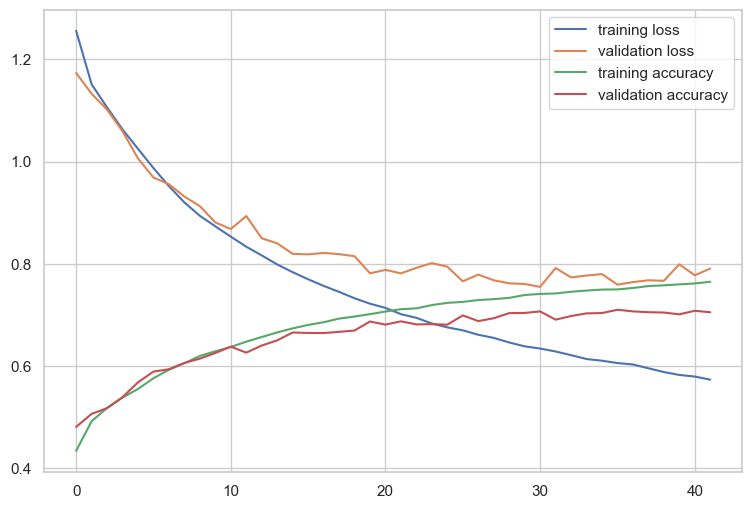

In [47]:
""""Let's make plots to display the trajectory of loss function and accuracy on training and validation sets.
As we can see in both cases, at 30th (from 42) epoch model stopped endorsing progress.
The accuracies shown on plots are almost the mirror images of loss values."""

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
'''To display confusion matrix we should define the class containing an estimator,
which results we're going to see.'''

class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(deep_model, list(brands))

885/885 [==============================] - 2s 2ms/step


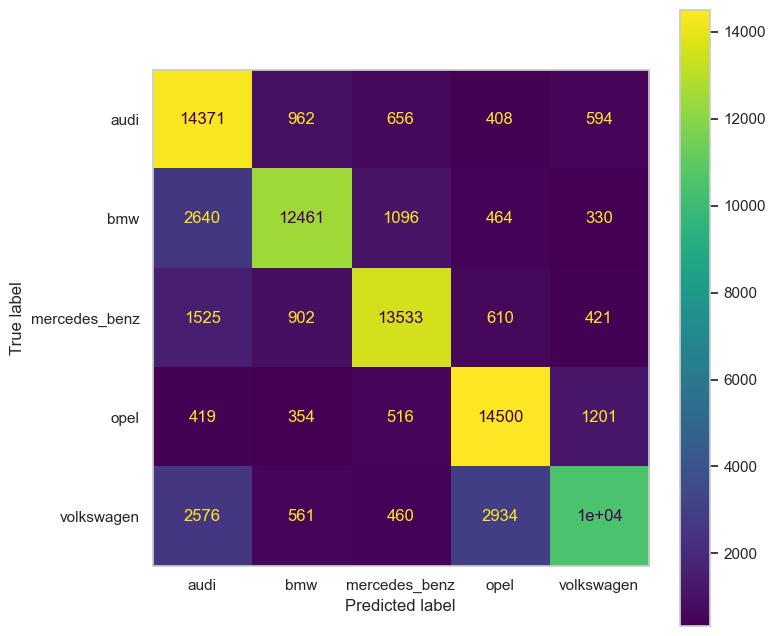

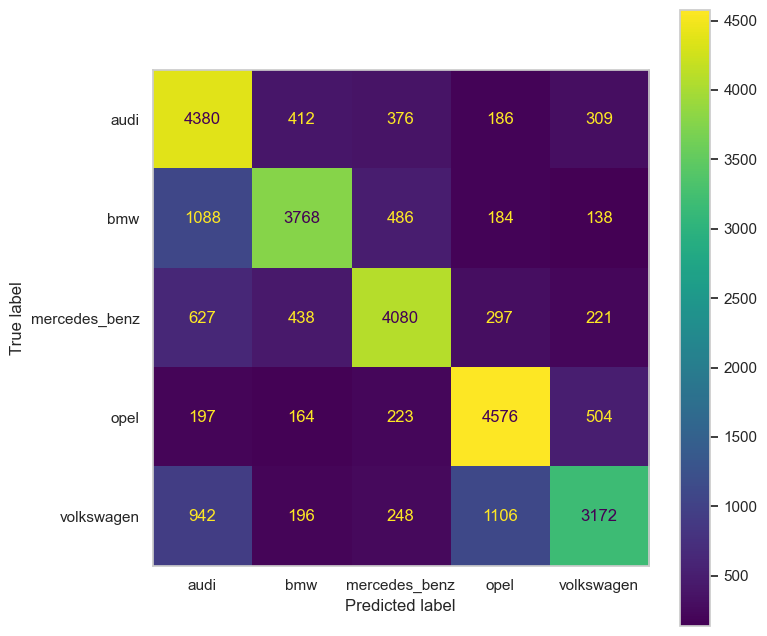

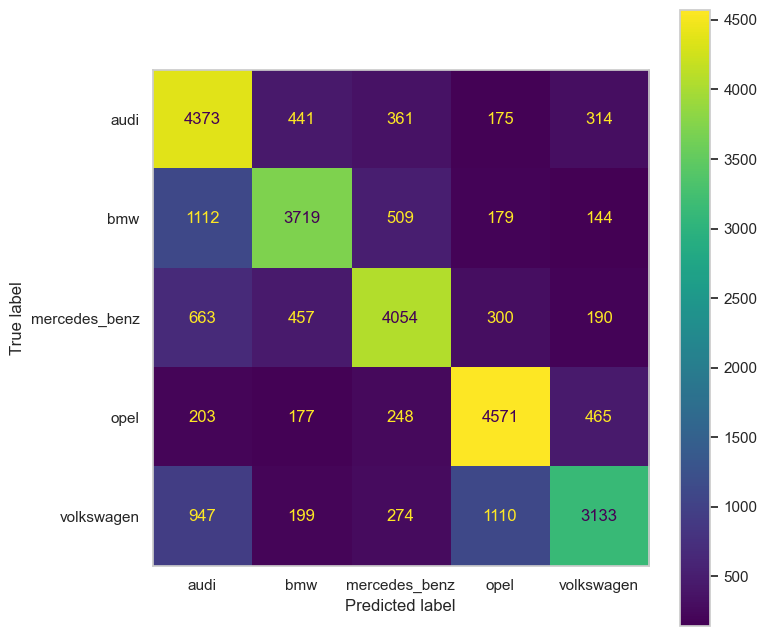

In [49]:
'''Now we're using predefined function to show confusion matrixes of every prediction.'''

conf_matrix_show(classifier, X_train_sc, y_train, list(brands))
conf_matrix_show(classifier, X_val_sc, y_val, list(brands))
conf_matrix_show(classifier, X_test_sc, y_test, list(brands))

In [50]:
'''Also this model has some problems in classifying VWs and - what's surprising - BMWs,
but it has solid metrics.
The next model is going to be more simple - less layers (5) and neurons in hidden layers (500-250-100-50), 
and, what's our intention, faster in training. We'll also make the batch larger and decrease number of epochs.'''

deep_model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(500, activation='relu'), #ReLU simplifies the computing and solves the disappearing gradient problem
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

deep_model2.compile(
    optimizer='adam', #when using ADAM, we don't have to tune learning rate
    loss='sparse_categorical_crossentropy', #when we have two and more labels, SCC is recommended
    metrics='accuracy'
)

callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                  patience=6)
]

start = time.time()

history = deep_model2.fit(
    X_train_sc, y_train, batch_size=50,
    validation_data=(X_val_sc, y_val),
    epochs=50, callbacks=callback
)
    
stop = time.time()
mins = math.floor((stop - start)/60)
seconds = math.ceil((stop - start)%60)
print(f"Training time of selected Keras Dense model: {mins} mins and {seconds} s.")

Epoch 1/50
1700/1700 [==============================] - 8s 4ms/step - loss: 1.2281 - accuracy: 0.4552 - val_loss: 1.1534 - val_accuracy: 0.4939
Epoch 2/50
1700/1700 [==============================] - 8s 4ms/step - loss: 1.1394 - accuracy: 0.4985 - val_loss: 1.1294 - val_accuracy: 0.5018
Epoch 3/50
1700/1700 [==============================] - 7s 4ms/step - loss: 1.1030 - accuracy: 0.5191 - val_loss: 1.0981 - val_accuracy: 0.5204
Epoch 4/50
1700/1700 [==============================] - 7s 4ms/step - loss: 1.0693 - accuracy: 0.5368 - val_loss: 1.0693 - val_accuracy: 0.5304
Epoch 5/50
1700/1700 [==============================] - 7s 4ms/step - loss: 1.0346 - accuracy: 0.5507 - val_loss: 1.0340 - val_accuracy: 0.5488
Epoch 6/50
1700/1700 [==============================] - 7s 4ms/step - loss: 1.0021 - accuracy: 0.5686 - val_loss: 1.0044 - val_accuracy: 0.5680
Epoch 7/50
1700/1700 [==============================] - 8s 4ms/step - loss: 0.9750 - accuracy: 0.5827 - val_loss: 0.9752 - val_accuracy:

2655/2655 [==============================] - 4s 2ms/step
Accuracy on training data: 0.7630246877670288% 
 Error on training data: 0.2369753122329712
2655/2655 [==============================] - 4s 2ms/step
Accuracy on validation data: 0.684123158454895% 
 Error on training data: 0.315876841545105
885/885 [==============================] - 1s 2ms/step
Accuracy on test data: 0.6778374314308167% 
 Error on test data: 0.32216256856918335


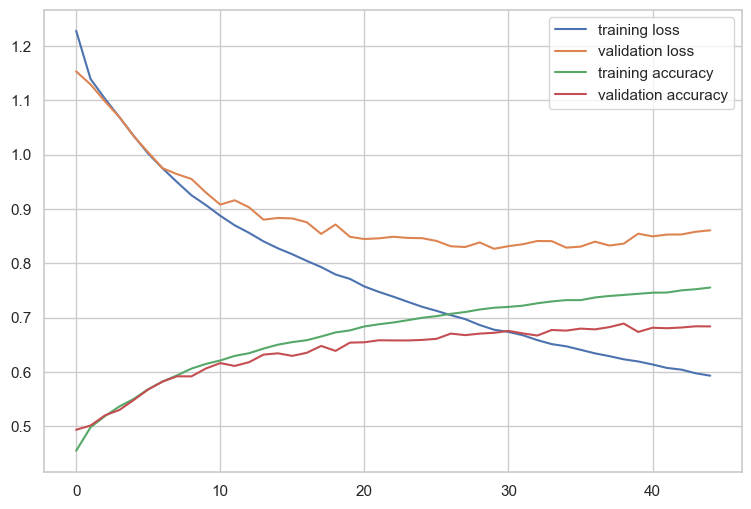

In [52]:
'''The less complex model's scores were about 76% on training and 68% on evaluating sets.
Again, at about 30th epoch (from 45) progress of training became insignificant.'''

pred_train = deep_model2.predict(X_train_sc)
scores_train = deep_model2.evaluate(X_train_sc, y_train, verbose=0)
print(f'Accuracy on training data: {scores_train[1]}% \n Error on training data: {1 - scores_train[1]}')   

pred_val = deep_model2.predict(X_train_sc)
scores_val = deep_model2.evaluate(X_val_sc, y_val, verbose=0)
print(f'Accuracy on validation data: {scores_val[1]}% \n Error on training data: {1 - scores_val[1]}')   
 
pred_test = deep_model2.predict(X_test_sc)
scores_test = deep_model2.evaluate(X_test_sc, y_test, verbose=0)
print(f'Accuracy on test data: {scores_test[1]}% \n Error on test data: {1 - scores_test[1]}')  

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.grid(True)
plt.show()

885/885 [==============================] - 1s 2ms/step


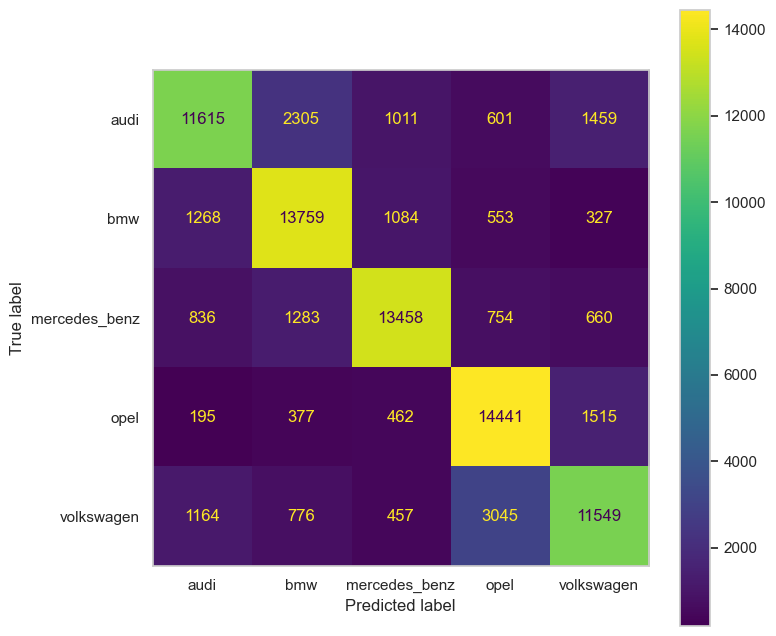

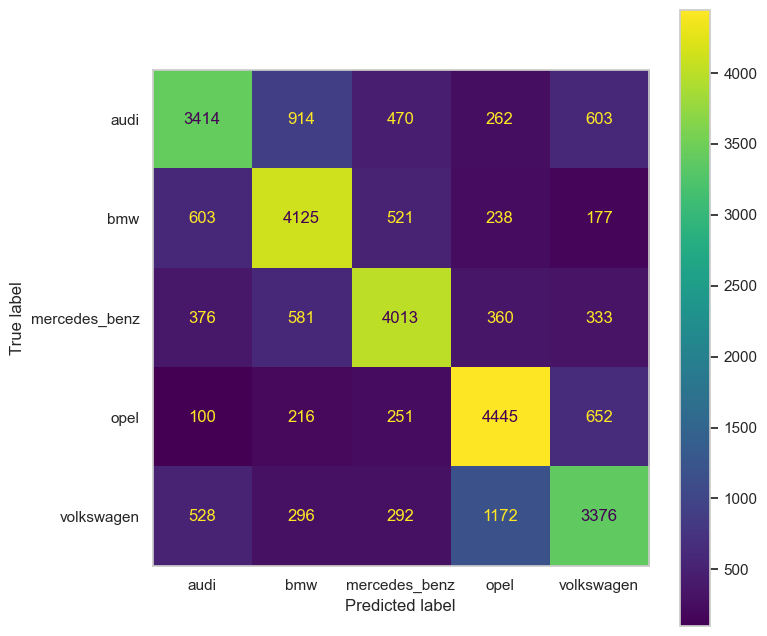

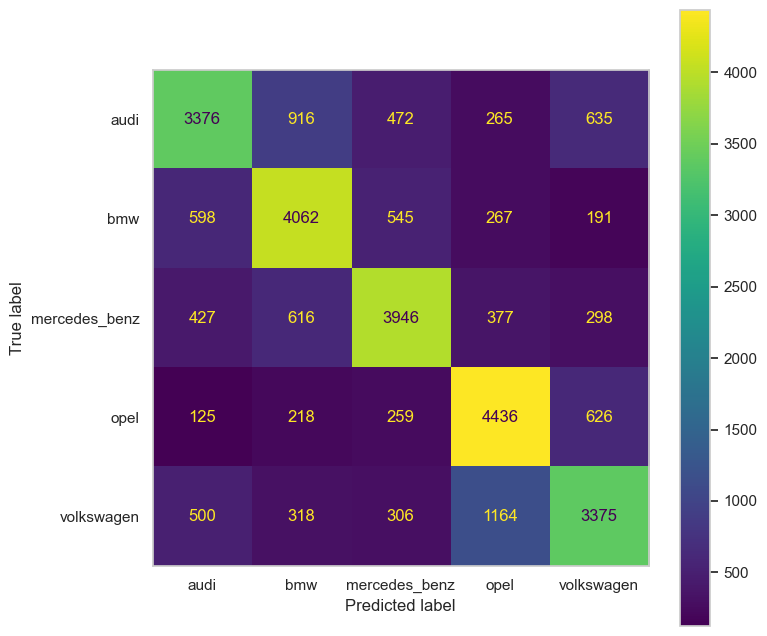

In [54]:
'''Confusion matrix shows that the problem with this model is weak recall of VW and Audi records.
On validation and test sets that brands had only about 60% of true positive predictions.'''

classifier = estimator(deep_model2, list(brands))

conf_matrix_show(classifier, X_train_sc, y_train, list(brands))
conf_matrix_show(classifier, X_val_sc, y_val, list(brands))
conf_matrix_show(classifier, X_test_sc, y_test, list(brands))

In [60]:
'''Final conclusions:
- classification problem wasn't easy to solve - data had many dependencies not catched by almost all of
tradition machine learning algorithms from sklearn, because distributions of majority of features 
were overlapping,
- RandomForestClassifier turned out as effective alternative to neural networks - hard to overfit, 
seeing most of dependencies in data and more accurate than deep learning models,
- simple neural network models are not enough to make efficient forecasts - to make effective model,
we need to build complex architecture and we have no warrancy of better results than RFC,
- therefore RFC more is the best of above because of its results, easiness of implementation and learning time.
'''

"Final conclusions:\n- classification problem wasn't easy to solve - data had many dependencies not catched by majority of\ntradition machine learning algorithms from sklearn,\n- RandomForestClassifier turned out as effective alternative to neural networks - hard to overfit, \nseeing most of dependencies in data,\n- to solve problem via neural networks with comparable scores to RFC, we must build very expanded architecture\nwith long learning time and great computing requirements."